In [1]:
!pip install -U git+https://github.com/Adapter-Hub/adapter-transformers.git
!pip install datasets

  Cloning https://github.com/Adapter-Hub/adapter-transformers.git to /tmp/pip-req-build-4b1039ck
  Running command git clone -q https://github.com/Adapter-Hub/adapter-transformers.git /tmp/pip-req-build-4b1039ck
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for adapter-transformers: filename=adapter_transformers-2.0.1-cp37-none-any.whl size=2099116 sha256=d0d83d5916031bf64a1805b23780bef58775c8407469ec8d3ad1ccd8b58fd45c
  Stored in directory: /tmp/pip-ephem-wheel-cache-vvcdwurf/wheels/b0/56/c9/5bf1c51cd513412090ad751ab10fc025210176bf0a82dd8af3
Successfully built adapter-transformers
  Found existing installation: adapter-transformers 2.0.1
    Uninstalling adapter-transformers-2.0.1:
      Successfully uninstalled adapter-transformers-2.0.1


In [2]:
cd drive/MyDrive/CAMemBERT-Adapters/

/content/drive/MyDrive/CAMemBERT-Adapters


Using custom data configuration default-bee46334fe9f6149
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-bee46334fe9f6149/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModelWithHeads: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModelWithHeads from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModelWithHeads from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,Training Loss,Validation Loss,Loss,F1,Accuracy
1,No log,0.450902,0.433011,0.847222,0.769874
2,0.480500,0.481819,0.440215,0.825153,0.761506
3,0.480500,0.467939,0.406496,0.830534,0.767782


{'train_loss': 0.43301111459732056, 'train_f1': 0.8486486486486486, 'train_accuracy': 0.7895569620253164, 'eval_loss': 0.45090213418006897, 'eval_f1': 0.8472222222222222, 'eval_accuracy': 0.7698744769874477}
{'train_loss': 0.4402145743370056, 'train_f1': 0.8290863890615288, 'train_accuracy': 0.7824367088607594, 'eval_loss': 0.48181912302970886, 'eval_f1': 0.8251533742331288, 'eval_accuracy': 0.7615062761506276}
{'train_loss': 0.40649640560150146, 'train_f1': 0.8500152114390022, 'train_accuracy': 0.8049841772151899, 'eval_loss': 0.46793919801712036, 'eval_f1': 0.830534351145038, 'eval_accuracy': 0.7677824267782427}


Overwriting existing adapter 'seq_class_bert_adaptors_fce_grammar_dev_set_5epochs_16bs_4E-5lr_1layers_froze_fce_grammar'.
Overwriting existing head 'seq_class_bert_adaptors_fce_grammar_dev_set_5epochs_16bs_4E-5lr_1layers_froze_fce_grammar'



__________test set results__________


{'eval_loss': 0.4665450155735016, 'eval_f1': 0.8171206225680934, 'eval_accuracy': 0.7608142493638677}
_________plotting history__________
defaultdict(<class 'list'>, {('_loss', 'train'): [0.43301111459732056, 0.4402145743370056, 0.40649640560150146], ('_f1', 'train'): [0.8486486486486486, 0.8290863890615288, 0.8500152114390022], ('_accuracy', 'train'): [0.7895569620253164, 0.7824367088607594, 0.8049841772151899], ('_loss', 'eval'): [0.45090213418006897, 0.48181912302970886, 0.46793919801712036], ('_f1', 'eval'): [0.8472222222222222, 0.8251533742331288, 0.830534351145038], ('_accuracy', 'eval'): [0.7698744769874477, 0.7615062761506276, 0.7677824267782427], ('_runtime', 'train'): [253.0028], ('_samples_per_second', 'train'): [6.245]})


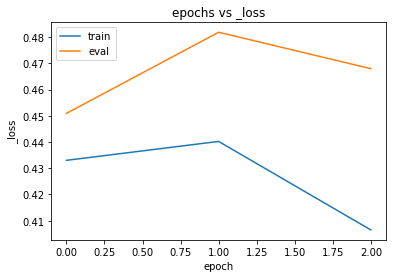

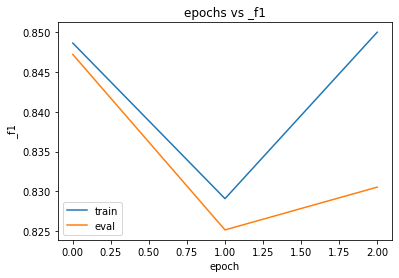

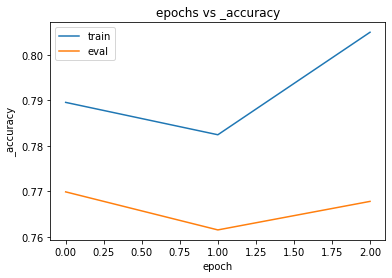

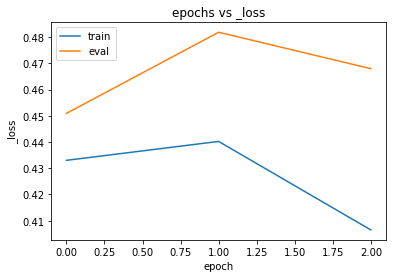

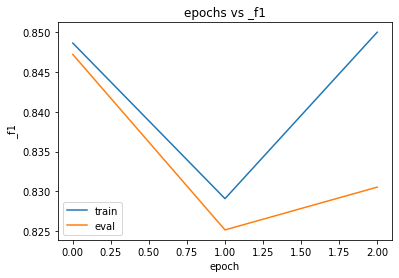

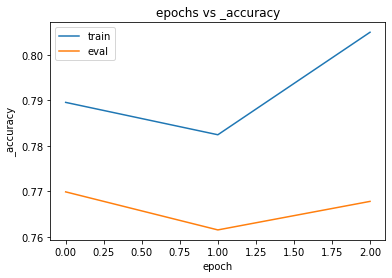

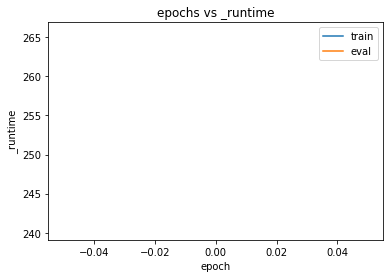

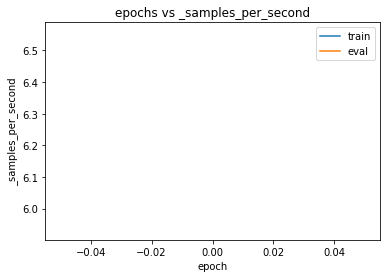

In [5]:
# import os, sys
# currentdir = os.path.dirname(os.path.realpath(__file__))
# preprocess_mod_ind = currentdir.split('/').index('CAMemBERT-Adapters')
# preprocess_mod_path = '/'.join(currentdir.split('/')[:preprocess_mod_ind+1])
# sys.path.append(preprocess_mod_path)
from transformers import AutoTokenizer,EarlyStoppingCallback,TrainingArguments,AutoModelWithHeads,AutoConfig
from datasets import load_dataset,load_metric
from src.models.trainers import BaseTrainer
from src.models.running import *
from sklearn.metrics import f1_score,accuracy_score
import torch
import numpy as np

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch[tokenize_col], max_length=max_n_tokens, truncation=True, padding="max_length")

def compute_metrics(p):
    logits, labels = np.argmax(p.predictions, axis=1),p.label_ids
    logits = logits.flatten()
    labels = labels.flatten()
    metrics_dic = {}
    metrics_dic['f1'] = f1_score(logits, labels)
    metrics_dic['accuracy'] = accuracy_score(logits,labels)
    return metrics_dic

es = 2
lr = 4e-5
bs = 16
epochs = 5
frozen_layers = 1
metric_for_best_model = 'f1'
dev = True

tokenize_col='tokens'
max_n_tokens=64
extra_cols_for_dataset=[]

params = generate_parameters(es,lr,bs,epochs,frozen_layers,metric_for_best_model,dev,max_n_tokens)

pre_trained_model_name = 'bert-base-uncased'
dataset_title = 'fce_grammar'
task = 'ged'
subtask = 'seq_class'
abrev_name = f'seq_class_bert_adaptors_{dataset_title}'

file_paths = generate_file_paths(dataset_title,task,subtask,params,abrev_name)

dataset_dic = {'train':file_paths['train_file_path'],'test':file_paths['test_file_path'],'val':file_paths['val_file_path']}

dataset = load_dataset('csv', data_files=dataset_dic)
tokenizer = AutoTokenizer.from_pretrained(pre_trained_model_name)
dataset = dataset.map(encode_batch, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask","labels"]+extra_cols_for_dataset)

config = AutoConfig.from_pretrained(
    pre_trained_model_name,
    num_labels=2,
)
model = AutoModelWithHeads.from_pretrained(
    pre_trained_model_name,
    config=config,
)

adapter_names=f'{file_paths["full_model_name"]}_{dataset_title}'
# Add a new adapter
model.add_adapter(adapter_names)
# Add a matching classification head
model.add_classification_head(
    adapter_names,
    num_labels=2,
  )
# Activate the adapter
model.train_adapter(adapter_names)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

training_args = base_training_args(params,file_paths)

callbacks = [EarlyStoppingCallback(es)]

trainer = BaseTrainer(model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    compute_metrics=compute_metrics,
    callbacks=callbacks,)

trainer.train()

print()
print('__________test set results__________')
trainer.evaluate(dataset['test'],testing=True)
hist = trainer.state.log_history[-1]
eval_data = generate_eval_data(hist,params,task,subtask,pre_trained_model_name)
update_evaluation_results_for_this_model(f'{file_paths["evaluation_file_this_model"]}',eval_data)
update_evaluation_results_for_subtask(file_paths)

print('_________plotting history__________')
trainer.plot_history(file_paths['plots_path'],f'{file_paths["full_model_name"]}')